# BOOM: Tephrochronology dataset of the Southern and Austral volcanic zones of the Andes.

## Machine Learning analysis

In [41]:
import pandas as pd
import numpy as np
from scipy import stats
import missingno as msno
import plotly.express as px
import sys
import time
from itertools import product
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GroupShuffleSplit
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.linear_model import BayesianRidge
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance

In [42]:
sys.path.insert(1, '../Scripts')
from functions import colores
from utils import GridSearchCV_with_groups
from utils import plot_scatterplots
from utils import plot_confusion_matrix

ImportError: cannot import name 'plot_confusion_matrix' from 'utils' (../Scripts/utils.py)

In [3]:
#load the data
df = pd.read_csv("../Data/BOOMDataset.csv", encoding = 'latin1', low_memory =False )

In [4]:
df.describe()

Magnitude          Vei      Latitude     Longitude       14C_Age  \
count  5533.000000  3984.000000  16738.000000  16738.000000    384.000000   
mean      4.645527     4.596135    -41.558985    -72.107202   5729.721354   
std       0.938234     0.700271      3.214217      0.849289   4185.434745   
min       2.000000     2.000000    -53.750000    -75.680000     90.000000   
25%       4.000000     4.000000    -42.890833    -72.419000   2078.750000   
50%       5.000000     5.000000    -40.368284    -71.972250   4450.000000   
75%       5.300000     5.000000    -39.546000    -71.630000   9322.500000   
max       6.200000     6.000000    -38.438690    -68.700000  14840.000000   

       14C_Age_Error  40Ar39Ar_Age  40Ar39Ar_Age_Error          SiO2  \
count     384.000000     10.000000            10.00000  13791.000000   
mean       62.677083  10441.800000          1850.20000     63.719141   
std        47.337022   5742.516402          1136.15353      7.320255   
min        19.000000     18.000000             2.00000     45.972845   
25%        36.000000   6525.000000          1100.00000     56.663051   
50%        50.000000  11750.000000          1750.00000     64.530000   
75%        75.000000  14250.000000          2700.00000     69.697550   
max       400.000000  18700.000000          3800.00000     79.762073   

               TiO2  ...  Fe2O3T_normalized  FeOT_normalized  MnO_normalized  \
count  13791.000000  ...         620.000000     12233.000000    12497.000000   
mean       0.967836  ...           8.403211         5.910409        0.156548   
std        0.572116  ...           2.323430         3.347711        0.158753   
min        0.000000  ...           1.399078         0.274613       -0.041335   
25%        0.500900  ...           6.823851         3.350335        0.104559   
50%        0.946975  ...           8.839089         4.884043        0.151574   
75%        1.360750  ...          10.109943         9.188012        0.193294   
max        6.280000  ...          15.440233        15.311673        4.471731   

       MgO_normalized  CaO_normalized  Na2O_normalized  K2O_normalized  \
count    13025.000000    13025.000000     13025.000000    13025.000000   
mean         1.949918        4.378921         4.494148        2.055788   
std          1.737541        2.708942         0.872777        0.951714   
min          0.000000        0.345768         0.983520        0.008971   
25%          0.525689        1.998904         3.804828        1.191817   
50%          1.250123        3.514872         4.561725        1.894722   
75%          3.230767        6.883497         5.151625        2.917573   
max         16.174723       12.001885         7.781000        5.880588   

       P2O5_normalized  Cl_normalized  Total_normalization  
count     10351.000000    4646.000000         13025.000000  
mean          0.227642       0.147719            98.749406  
std           0.135126       0.061761             1.606102  
min           0.000000       0.001000            89.403912  
25%           0.122664       0.097194            97.881800  
50%           0.223274       0.143800            98.975100  
75%           0.313450       0.191679            99.817868  
max           1.563130       0.610061           103.070000  

[8 rows x 61 columns]

In [5]:
n, p = df.shape
print(f'This dataset consists of {n} samples and {p} variables.')

This dataset consists of 16738 samples and 100 variables.


 ## 1 - Data cleaning

The target variable will be the volcano ID. Let's look at it.

In [6]:
y = len(df['Volcano'].unique())
print(f'There are {y} different volcanos.')
df['Volcano'].value_counts()

There are 33 different volcanos.


Mocho-Choshuenco         2691
Chaitén                  2343
Unknown                  1931
Puyehue-Cordón Caulle    1924
Llaima                   1479
Quetrupillán             1214
Hudson                    989
Villarrica                865
Michinmahuida             619
Melimoyu                  464
Monte Burney              421
Antillanca-Casablanca     242
Reclus                    193
Carrán-Los Venados        186
Calbuco                   179
Huanquihue Group          176
Caburga-Huelemolle        135
Mentolat                  121
Osorno                    102
Lanín                      91
Sollipulli                 75
Apagado                    48
Aguilera                   45
Yate                       43
Lautaro                    41
Hornopirén                 27
Macá                       23
Subsidiary Vcha dome       21
Cay                        17
Huequi                     11
Corcovado                  11
Yanteles                    7
Cordón Cabrera              4
Name: Volc

#### 1.1 - We will drop the volcanoes for which we have less than 10 observations.

In [7]:
Yanteles = df.Volcano=='Yanteles'
CordonC = df.Volcano=='Cordón Cabrera'
df = df.loc[~Yanteles & ~CordonC]
n, p = df.shape
print(f'The dataset now has {n} samples.')

The dataset now has 16727 samples.


#### 1.2 - Dropping rows corresponding to samples not analyzed for geochemistry, as well as outliers and samples for which the volcanic source is uncertain.

In [8]:
df['TypeOfRegister'].value_counts()

Pyroclastic material    15848
Effusive material         395
Organic matter            381
Name: TypeOfRegister, dtype: int64

In [9]:
is_register = df.TypeOfRegister.isin(['Pyroclastic material','Effusive material'])

In [10]:
df['Flag'].value_counts(dropna=False)

NaN                                                    10361
EventName_Issue                                         2249
Geochemistry_Issue                                      1731
Position_Issue                                           547
SampleID_Issue                                           545
Position_Issue, EventName_Issue                          244
DOI_Issue                                                207
VolcanicSource_Issue                                     160
Position_Issue, Geochemistry_Issue                       112
SampleID_Issue, Geochemistry_Issue                        89
DOI_Issue, Geochemistry_Issue                             87
VolcanicSource_Issue, Geochemistry_Issue                  67
SampleID_Issue, EventName_Issue                           58
Position_Issue, DOI_Issue                                 36
VolcanicSource_Issue, EventName_Issue                     33
Position_Issue, DOI_Issue, Geochemistry_issue             30
Position_Issue,  Geochem

In [11]:
isnot_outlier = df.Flag.str.contains('Outlier', na=False, case=False) == False

In [12]:
isnot_VolcanicSourceIssue = df.Flag.str.contains(
    'VolcanicSource_Issue', na=False, case=False) == False

In [13]:
df = df.loc[is_register & isnot_outlier & isnot_VolcanicSourceIssue]

In [14]:
n, _ = df.shape
print(f'There are {n} rows left.')

There are 15960 rows left.


#### 1.3 - Replace element concentrations registered as "0" with below detection limit (bdl). Because a value equal to zero is not possible to determine with the current analytical techniques.

In [15]:
for elemento in ["SiO2","TiO2","Al2O3","FeO","Fe2O3",
                 "MnO","MgO","CaO","Na2O","K2O","P2O5",
                 "Cl",'Rb','Sr','Y','Zr','Nb',
                 'Cs','Ba','La','Ce','Pr','Nd',
                 'Sm','Eu','Gd','Tb','Dy','Ho',
                 'Er','Tm','Yb','Lu','Hf','Ta',
                 'Pb','Th','U']:
    df[elemento] = df[elemento].replace(to_replace=0, value='bdl')

In [16]:
# ####  1.4 - Drop rows where data is Missing Not At Random (increases the performance).
# for columna in df.columns:
#     df=df[(df[columna]!= 'Over range')&
#           (df[columna]!= 'bdl')&
#           (df[columna]!= '<0.1')&
#           (df[columna]!= '<1')&
#           (df[columna]!= '<5')&
#           (df[columna]!= '<6')&
#           (df[columna]!= '<10')]

#### 1.4 - Replace the various missing values placeholders by np.nan

In [17]:
df.replace(to_replace='n.a.', value=np.nan, inplace=True)
df.replace(to_replace='Not analyzed', value=np.nan, inplace=True)
df.replace(to_replace='-', value=np.nan, inplace=True)
df.replace(to_replace='Not determined', value=np.nan, inplace=True)
df.replace(to_replace='n.d', value=np.nan, inplace=True)
df.replace(to_replace='n.d.', value=np.nan, inplace=True)
df.replace(to_replace='<0.01', value=np.nan, inplace=True)
df.replace(to_replace='<0.1', value=np.nan, inplace=True)
df.replace(to_replace='<1', value=np.nan, inplace=True)
df.replace(to_replace='<5', value=np.nan, inplace=True)
df.replace(to_replace='<6', value=np.nan, inplace=True)
df.replace(to_replace='<10', value=np.nan, inplace=True)
df.replace(to_replace='Over range', value=np.nan, inplace=True)
df.replace(to_replace='bdl', value=np.nan, inplace=True)

In [18]:
# 1.4 Drop rows where MnO was not analyzed, as it is Missing Not At Random
# BOOM_geodf = BOOM_geodf.replace(np.nan,-1)
# BOOM_geodf = BOOM_geodf[((BOOM_geodf['SiO2_normalized']!=-1)&(BOOM_geodf['MnO_normalized']!=-1))|(BOOM_geodf['SiO2_normalized']==-1)]
# BOOM_geodf = BOOM_geodf.replace(-1, np.nan)

# BOOM_geodf = BOOM_geodf.reset_index(drop=True)

#### 1.5 - calculate FeOT for all samples

In [19]:
ind = (~df.SiO2_normalized.isna() &
       df.FeOT_normalized.isna() &
       ~df.FeO_normalized.isna() &
       ~df.Fe2O3_normalized.isna()
      )
df.loc[ind,'FeOT_normalized'] = df.FeO_normalized.loc[ind]+df.Fe2O3_normalized.loc[ind]*0.899

ind = (~df.SiO2_normalized.isna() &
       df.FeOT_normalized.isna() &
       ~df.Fe2O3T_normalized.isna()
      )
df.loc[ind,'FeOT_normalized'] = df.Fe2O3T_normalized.loc[ind]*0.899

In [20]:
# 2. Define target attributes (volcano and events) and list of SampleIDs
# to consider in the split train/test sets
df['Volcano'] = df['Volcano'].astype("category")
df['Event'] = df['Event'].astype("category")
df['SampleID'] = df['SampleID'].astype("category")

Since all observations from a sampleID should be in the same set (train or test), we will remove the observations corresponding to a volcan having observations from a single sampleID.

In [21]:
# Check wether all volcanos have at least two sampleIDs
co = pd.crosstab(df.Volcano, df.SampleID)
_, n_sampleID = co.shape
print(f'There are {n_sampleID} unique samples IDs')

There are 2385 unique samples IDs


In [22]:
is_nonzero = co > 0
n_volcan_per_sampleID = is_nonzero.sum(axis=0)
unique, counts = np.unique(n_volcan_per_sampleID, return_counts=True)
ind_ids = np.where(is_nonzero.sum(axis=0) == 2)[0]
print(f'There are {len(ind_ids)} sampleIDs which contain several observations from several volcanoes:')
print([co.columns[ind_ids].values[i] for i in range(len(ind_ids))])

There are 3 sampleIDs which contain several observations from several volcanoes:
['CLD159A', 'T-35', 'T-36']


In [23]:
n_sampleID_per_volcan = is_nonzero.sum(axis=1)
ind_ids = np.where(n_sampleID_per_volcan == 1)[0]
print(f'There is {len(ind_ids)} volcan whose observations all come from the same sample IDs:')
print([co.index[i] for i in ind_ids])

There is 1 volcan whose observations all come from the same sample IDs:
['Subsidiary Vcha dome']


In [24]:
df = df[df.Volcano != co.index[ind_ids[0]]]

In [25]:
print(f'There are {len(df)} observations left.')

There are 15939 observations left.


In [26]:
# 3. Filter samples for which volcano id is unknown
df_unknown_volcano = df.loc[df.Volcano == 'Unknown']
df_unknown_event = df.loc[df.Event == 'Unknown']

df_volcanoes = df.loc[df.Volcano != 'Unknown'].copy()
df_events = df.loc[(df.Volcano != 'Unknown') & (df.Event != 'Unknown')].copy()

In [ ]:
# The major elements are often either all present or all absent
# So to build a matrix solely based on major elements, we need to take
# the volcanoes for which we have some data.
df_volcanoes_major = df_volcanoes.dropna(axis='rows',subset=['SiO2']).copy()

In [27]:
n = df_volcanoes.shape[0]
print(f'We now have {n} observations left')

We now have 14200 observations left


In [28]:
# 4. Retrieve the geochemical data, FeO, Fe2O3 and FeO2O3T are dropped because FeOT is
# a different expression of the same element
# P2O5 and Cl are sporadically analyzed 

majors = ['SiO2_normalized', 'TiO2_normalized', 'Al2O3_normalized',
           'FeOT_normalized', #'FeO_normalized', 'Fe2O3_normalized', 'Fe2O3T_normalized',
          'MnO_normalized','MgO_normalized', 'CaO_normalized', 'Na2O_normalized',
          'K2O_normalized', #'P2O5_normalized','Cl_normalized'
         ] 

X_major_volcanoes = df_volcanoes.loc[:, majors]
X_onlymajor_volcanoes = df_volcanoes_major.loc[:, majors]
X_major_events = df_events.loc[:, majors] 

traces = ['Rb', 'Sr', 'Y', 'Zr', 'Nb', 'Cs', 'Ba', 'La',
          'Ce', 'Pr', 'Nd', 'Sm', 'Eu', 'Gd', 'Tb', 'Dy',
          'Ho', 'Er', 'Tm', 'Yb', 'Lu', 'Hf', 'Ta', 'Pb',
          'Th', 'U']

X_traces_volcanoes = df_volcanoes.loc[:, traces]
X_traces_events = df_events.loc[:, traces] 

X_volcanoes = pd.concat([X_major_volcanoes, X_traces_volcanoes], axis=1)
X_events = pd.concat([X_major_events, X_traces_events], axis=1)

In [29]:
# The list of volcanoes and events and associated codes
yv = np.array(df_volcanoes['Volcano'].cat.codes, dtype='int8')
SampleID_volcanoes = np.array(df_volcanoes['SampleID'].cat.codes)

yv_major= np.array(df_volcanoes_major['Volcano'].cat.codes, dtype='int8')
SampleID_volcanoes_major = np.array(df_volcanoes_major['SampleID'].cat.codes)

ye = np.array(df_events['Event'].cat.codes, dtype='int8')
SampleID_events = np.array(df_events['SampleID'].cat.codes)

In [30]:
unique, counts = np.unique(SampleID_volcanoes, return_counts=True)
n_sampleID = len(counts)
print(f'There are {n_sampleID} sampleIDs')

There are 2182 sampleIDs


### 2 - Learn a  model with volcano as target variable and all chemical elements as features

**Visualize data**

In [31]:
# Print the number of sample observations per class
unique, counts = np.unique(yv, return_counts=True)
for u, c in zip(unique, counts):
    volcan = df_volcanoes.Volcano.cat.categories[u]
    print(f'id: {u}, volcán: \033[1m{volcan}\033[0m, sample observations: {c}')

n_classes = len(unique)

id: 0, volcán: Aguilera, sample observations: 42
id: 1, volcán: Antillanca-Casablanca, sample observations: 223
id: 2, volcán: Apagado, sample observations: 44
id: 3, volcán: Caburga-Huelemolle, sample observations: 134
id: 4, volcán: Calbuco, sample observations: 158
id: 5, volcán: Carrán-Los Venados, sample observations: 124
id: 6, volcán: Cay, sample observations: 8
id: 7, volcán: Chaitén, sample observations: 2282
id: 8, volcán: Corcovado, sample observations: 4
id: 9, volcán: Hornopirén, sample observations: 26
id: 10, volcán: Huanquihue Group, sample observations: 176
id: 11, volcán: Hudson, sample observations: 947
id: 12, volcán: Huequi, sample observations: 11
id: 13, volcán: Lanín, sample observations: 75
id: 14, volcán: Lautaro, sample observations: 38
id: 15, volcán: Llaima, sample observations: 1394
id: 16, volcán: Macá, sample observations: 12
id: 17, volcán: Melimoyu, sample observations: 456
id: 18, volcán: Mentolat, sample observations: 119
id: 19, volcán: Michinmahuid

<AxesSubplot:>

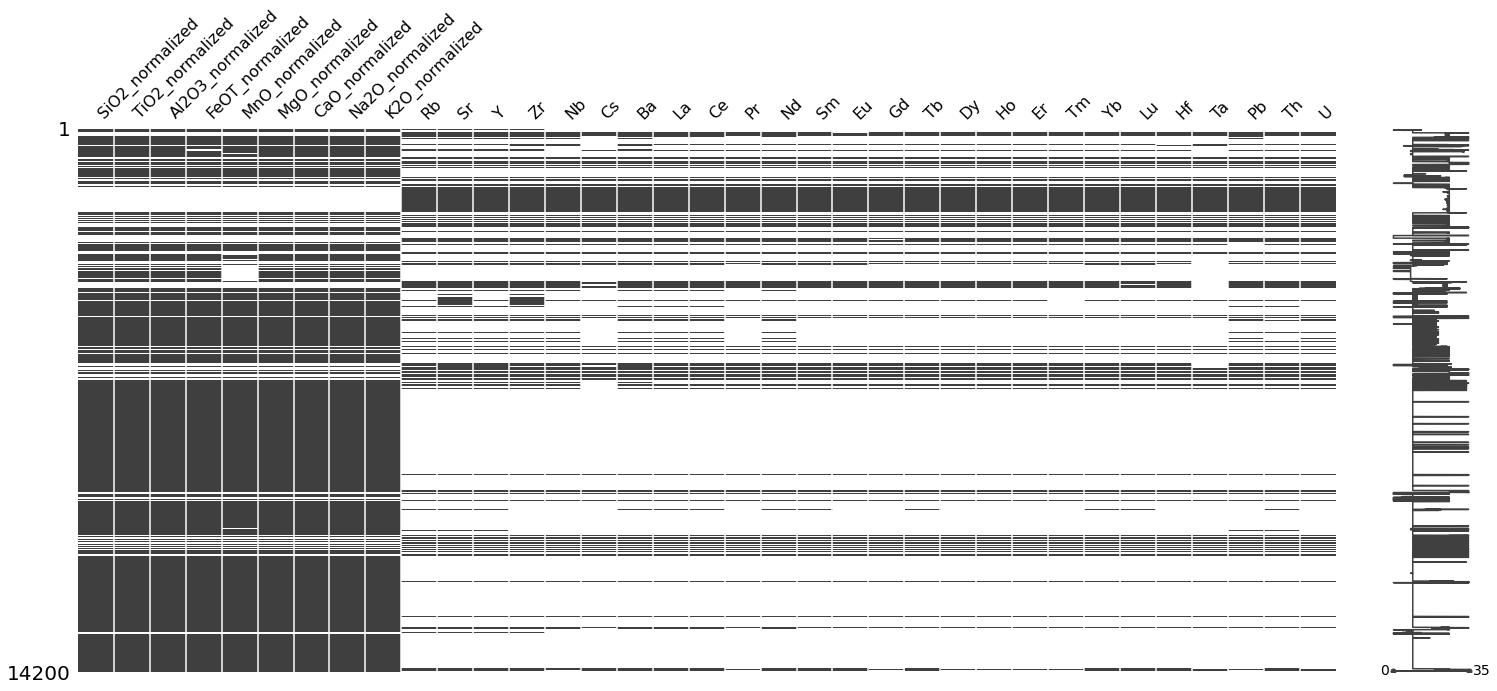

In [32]:
msno.matrix(X_volcanoes)

In [33]:
#df_volcanoes_lowSampleCount = df_volcanoes.dropna(axis = 'rows',subset=(['properties.SiO2']))[df_volcanoes['properties.Volcano'].isin(
#    ['Apagado','Cay','Corcovado','Cordón Cabrera','Huequi','Macá','Mentolat','Yanteles'])]
# fig = px.scatter(df_volcanoes, 'SiO2_normalized', 'K2O_normalized' ,
#                  color ='Volcano',# symbol = 'properties.SampleID',
#                  color_discrete_map = colores(df_volcanoes['Volcano'],type="volcano"),
#                  hover_data = ['SampleID','SampleObservationID',
#                                'Volcano','Event','Authors',
#                                'Flag'],width=800, height=500)
# fig.show()

**Examples of models for volcano prediction**

In [34]:
# K nearest neighbours
est = KNeighborsClassifier(n_neighbors=2,weights='distance')
grid = {'kneighborsclassifier__n_neighbors': [2, 5, 10],
        'kneighborsclassifier__weights': ['uniform', 'distance']}

In [35]:
# Multinomial logistic regression
est = LogisticRegression(penalty='l2', multi_class='multinomial',
                         solver='saga', class_weight='balanced',max_iter=5000)
grid = {'logisticregression__C': [1e-2, 1e-1, 1, 1e1, 1e2]}

In [36]:
# Desicion Tree
est = DecisionTreeClassifier(min_samples_leaf=3, min_samples_split=6, max_depth=10,
                             criterion='gini',class_weight='balanced')
grid = {'decisiontreeclassifier__max_depth': [50, 150, 300],
        'decisiontreeclassifier__min_samples_leaf': [3, 6, 9],
        'decisiontreeclassifier__min_samples_split': [3, 6, 9],
        'decisiontreeclassifier__ccp_alpha': [0, 0.01, 0.03]}

dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_impurity_split', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'random_state', 'splitter'])

In [37]:
# Random Forest
est = RandomForestClassifier(
    n_estimators=120, min_samples_leaf=1,
    random_state=0, class_weight='balanced',bootstrap=False,verbose=0)
# min_samples_split=5,'balanced_subsample' usar bootstrap false o
# class weight balanced_subsample no tiene gran efecto!
grid = {'randomforestclassifier__n_estimators': [50, 100, 125, 150],
        'randomforestclassifier__min_samples_leaf': [1, 2, 5]}

In [38]:
# Gradient Boosting
est = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=1)
   
grid = {'gradientboostingclassifier__n_estimators': [50, 100, 125, 150],
        'gradientboostingclassifier__min_samples_leaf': [1, 2, 5]}

Some observations come from the same pysical sample: they have the same SampleID.
In practice, the observations from a given sample all come at once, and it is unrealistic to suppose that we have access the vocano ID for some observations in the sample to predict the remaining obervations in the sample. As a result, we carefully define train/test splits so that all obervations from a given a sample are in the same split.

**Run cross-validation without grid search**

In [ ]:
# Define imputer
imp = IterativeImputer(random_state=0, min_value = 0, max_iter = 3000,
                       estimator=RandomForestRegressor(), initial_strategy = 'median')
# Define predictor
est_rf = RandomForestClassifier(n_estimators=120, min_samples_leaf=1,
                                random_state=0, class_weight='balanced')

clf = make_pipeline(imp, StandardScaler(), est_rf)

gss = GroupShuffleSplit(test_size=.20, n_splits=5, random_state=0)

cv_results = cross_validate(
    clf, X_volcanoes, yv, groups=SampleID_volcanoes,
    scoring=['accuracy', 'balanced_accuracy'], cv=gss
)

**Run grid search on a single train-test split**

In [39]:
imp = SimpleImputer()
est = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=1)
clf = make_pipeline(imp, StandardScaler(), est)
grid = {'gradientboostingclassifier__n_estimators': [100, 200],
        'gradientboostingclassifier__min_samples_leaf': [1, 5]}

gss = GroupShuffleSplit(test_size=.20, n_splits=1, random_state=0)

train_out, test_out = next(gss.split(X_volcanoes, groups=SampleID_volcanoes))
X_train_out = X_volcanoes.iloc[train_out]
yv_train_out = yv[train_out]
X_test_out = X_volcanoes.iloc[test_out]
yv_test_out = yv[test_out]
groups_train_out = SampleID_volcanoes[train_out]

est = GridSearchCV_with_groups(clf, grid, cv_test_size=0.2, cv_n_splits=5)
est.fit(X_train_out, yv_train_out, groups_train_out)
pred = est.predict(X_test_out)
ac = accuracy_score(yv_test_out, pred)
bc = balanced_accuracy_score(yv_test_out, pred)

print(f'Test set accuracy: {ac}')
print(f'Test set Balanced accuracy: {bc}')

Test set accuracy: 0.8215693299892511
Test set Balanced accuracy: 0.5568135903384158


**Plot predictions as scatterplots.**

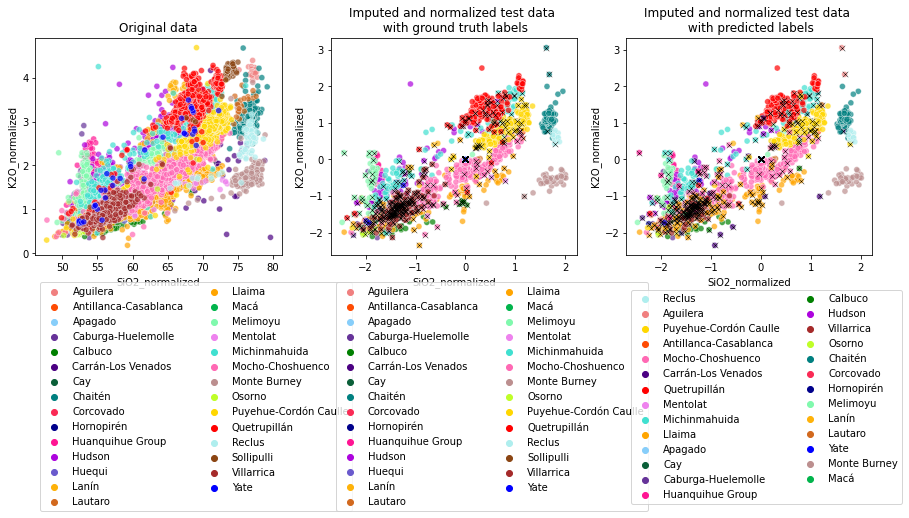

In [44]:
volcano_list = df.Volcano.cat.categories
best_est = est.best_estimator_

plot_scatterplots(X_volcanoes, yv, X_test_out, yv_test_out, best_est, pred, volcano_list)

**Plot the confusion matrix.**

<ipython-input-43-9809eb884322>:7: RuntimeWarning: invalid value encountered in true_divide
  cm = (cm.T/cm.sum(axis=1)).T
<ipython-input-43-9809eb884322>:18: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


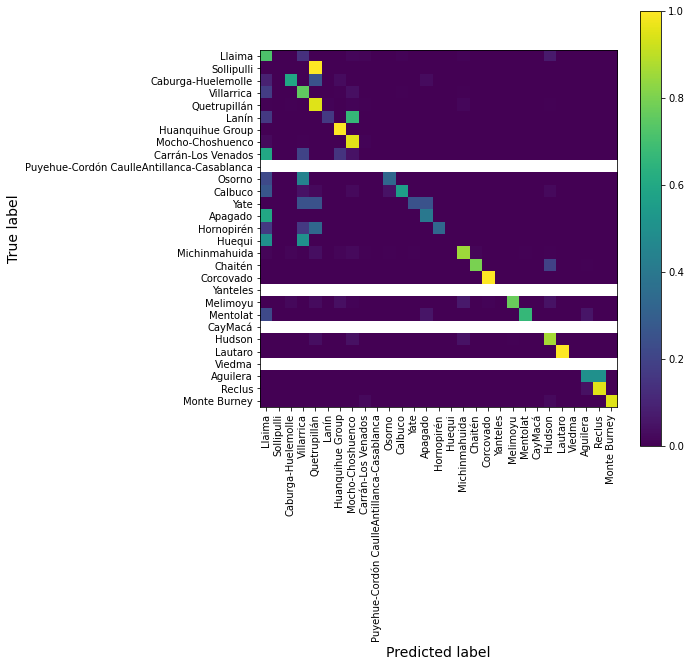

In [46]:
volcanoes_by_latitude = np.asarray([
    'Llaima','Sollipulli','Caburga-Huelemolle','Villarrica','Quetrupillán','Lanín',
    'Huanquihue Group','Mocho-Choshuenco','Carrán-Los Venados','Puyehue-Cordón Caulle'
    'Antillanca-Casablanca', 'Osorno','Calbuco','Yate','Apagado','Hornopirén','Huequi',
    'Michinmahuida','Chaitén','Corcovado', 'Yanteles','Melimoyu','Mentolat','Cay'
    'Macá','Hudson', 'Lautaro','Viedma','Aguilera','Reclus','Monte Burney'
])
yv_test_names = df.Volcano.cat.categories[yv_test_out]
yv_pred_names = df.Volcano.cat.categories[pred]

plot_confusion_matrix(yv_test_names, yv_pred_names, labels=volcanoes_by_latitude)

**Plot permutation importances.**

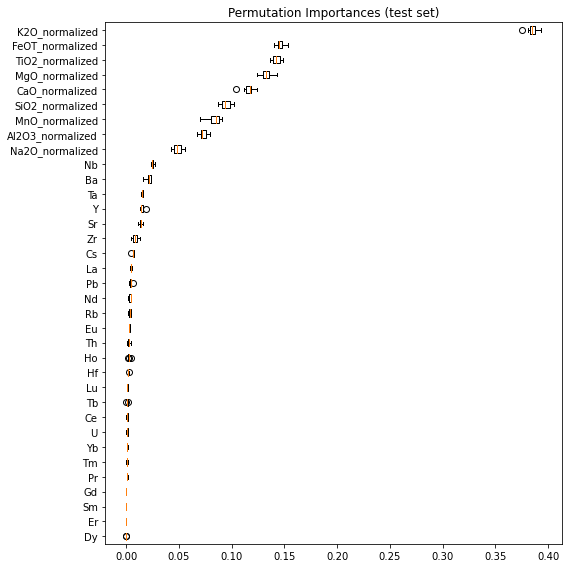

In [47]:
start = time.time()
result = permutation_importance(
    best_est, X_test_out, yv_test_out, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(8,8))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False,
    labels=X_test_out.columns[sorted_idx]
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()
end = time.time()

In [48]:
print('Run time: {}'.format((end-start)/60))

Run time: 0.49255298376083373


**Look at predictions on the set for which volcano IDs are unknown.**

In [49]:
test = df_unknown_volcano[df_unknown_volcano.SampleID=='LAZ-T1']
test = pd.concat((test.loc[:, majors], test.loc[:, traces]), axis=1)
print(test.shape)
unknown_sample_pred = best_est.predict(test)
unknown_sample_pred_name = df.Volcano.cat.categories[unknown_sample_pred]
print(unknown_sample_pred_name)
print(stats.mode(unknown_sample_pred_name)[0])

(18, 35)
Index(['Michinmahuida', 'Antillanca-Casablanca', 'Llaima',
       'Antillanca-Casablanca', 'Michinmahuida', 'Antillanca-Casablanca',
       'Michinmahuida', 'Llaima', 'Llaima', 'Llaima', 'Llaima', 'Llaima',
       'Llaima', 'Llaima', 'Llaima', 'Antillanca-Casablanca',
       'Antillanca-Casablanca', 'Antillanca-Casablanca'],
      dtype='object')
['Llaima']


### 3 - Learn a  model with volcano as target variable and only major elements as features

**Visualize data**

In [50]:
# Print the number of sample observations per class
unique, counts = np.unique(yv_major, return_counts=True)
for u, c in zip(unique, counts):
    volcan = df_volcanoes_major.Volcano.cat.categories[u]
    print(f'id: {u}, volcán: \033[1m{volcan}\033[0m, sample observations: {c}')

n_classes = len(unique)

id: 0, volcán: Aguilera, sample observations: 32
id: 1, volcán: Antillanca-Casablanca, sample observations: 116
id: 2, volcán: Apagado, sample observations: 32
id: 3, volcán: Caburga-Huelemolle, sample observations: 134
id: 4, volcán: Calbuco, sample observations: 142
id: 5, volcán: Carrán-Los Venados, sample observations: 124
id: 6, volcán: Cay, sample observations: 8
id: 7, volcán: Chaitén, sample observations: 985
id: 8, volcán: Corcovado, sample observations: 4
id: 9, volcán: Hornopirén, sample observations: 20
id: 10, volcán: Huanquihue Group, sample observations: 176
id: 11, volcán: Hudson, sample observations: 742
id: 12, volcán: Huequi, sample observations: 11
id: 13, volcán: Lanín, sample observations: 75
id: 14, volcán: Lautaro, sample observations: 38
id: 15, volcán: Llaima, sample observations: 1394
id: 16, volcán: Macá, sample observations: 5
id: 17, volcán: Melimoyu, sample observations: 346
id: 18, volcán: Mentolat, sample observations: 51
id: 19, volcán: Michinmahuida, 

<AxesSubplot:>

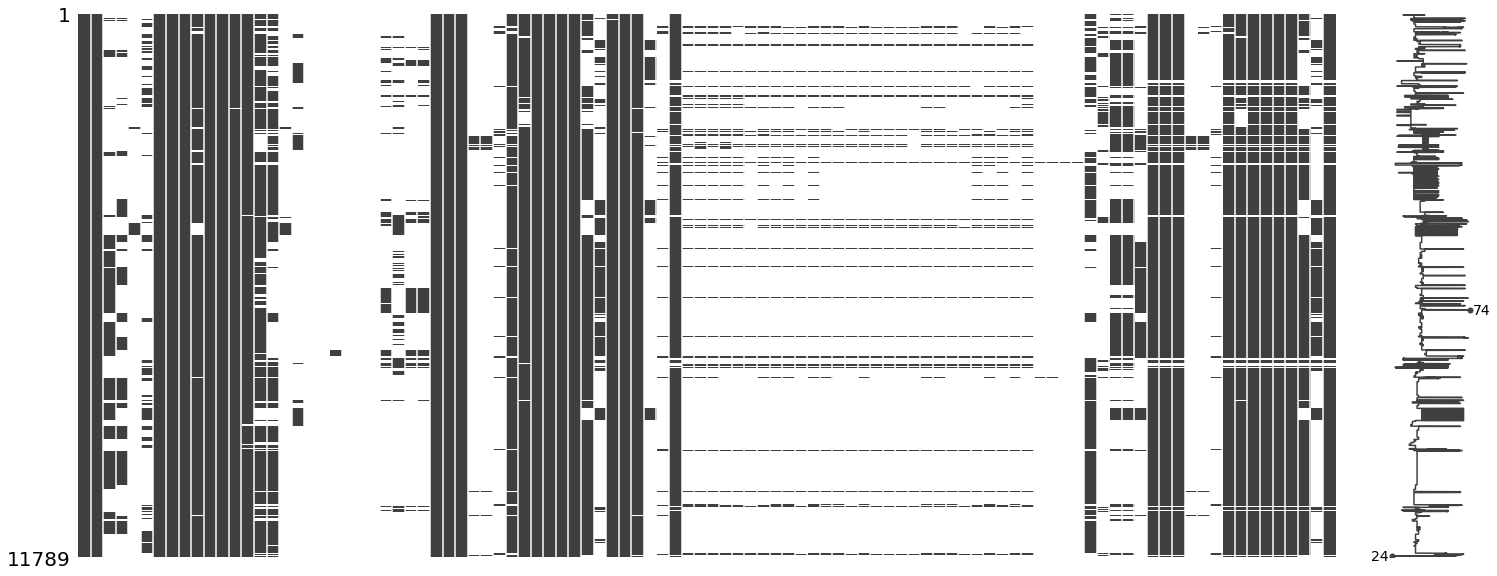

In [51]:
msno.matrix(df_volcanoes_major)

In [52]:
df_volcanoes_viz = df_volcanoes_major.dropna(
    axis = 'rows', subset=(['SiO2']))[df_volcanoes_major['Volcano'].isin(
    ['Apagado','Cay','Corcovado','Cordón Cabrera','Huequi','Macá','Mentolat','Yanteles'])]
fig = px.scatter(df_volcanoes_major, 'SiO2_normalized', 'K2O_normalized' ,
                 color ='Volcano',
                 color_discrete_map = colores(df_volcanoes['Volcano'], type="volcano"),
                 hover_data = ['SampleID', 'SampleObservationID',
                               'Volcano', 'Event', 'Authors',
                               'Flag'], width=800, height=500)
fig.show()

**Run grid search on a single train-test split**

In [53]:
imp = SimpleImputer()
est = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=1)
clf = make_pipeline(imp, StandardScaler(), est)
grid = {'gradientboostingclassifier__n_estimators': [100, 200],
        'gradientboostingclassifier__min_samples_leaf': [1, 5]}

gss = GroupShuffleSplit(test_size=.20, n_splits=1, random_state=0)

train_out, test_out = next(gss.split(X_onlymajor_volcanoes, groups=SampleID_volcanoes_major))
X_train_out = X_onlymajor_volcanoes.iloc[train_out]
yv_train_out = yv_major[train_out]
X_test_out = X_onlymajor_volcanoes.iloc[test_out]
yv_test_out = yv_major[test_out]
groups_train_out = SampleID_volcanoes_major[train_out]

est = GridSearchCV_with_groups(clf, grid, cv_test_size=0.2, cv_n_splits=5)
est.fit(X_train_out, yv_train_out, groups_train_out)
pred = est.predict(X_test_out)
ac = accuracy_score(yv_test_out, pred)
bc = balanced_accuracy_score(yv_test_out, pred)

print(f'Test set accuracy: {ac}')
print(f'Test set Balanced accuracy: {bc}')

Test set accuracy: 0.7757788503729706
Test set Balanced accuracy: 0.47002224045158475


/Users/lemorvan/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1854: UserWarning:

y_pred contains classes not in y_true



**Plot predictions as scatterplots**

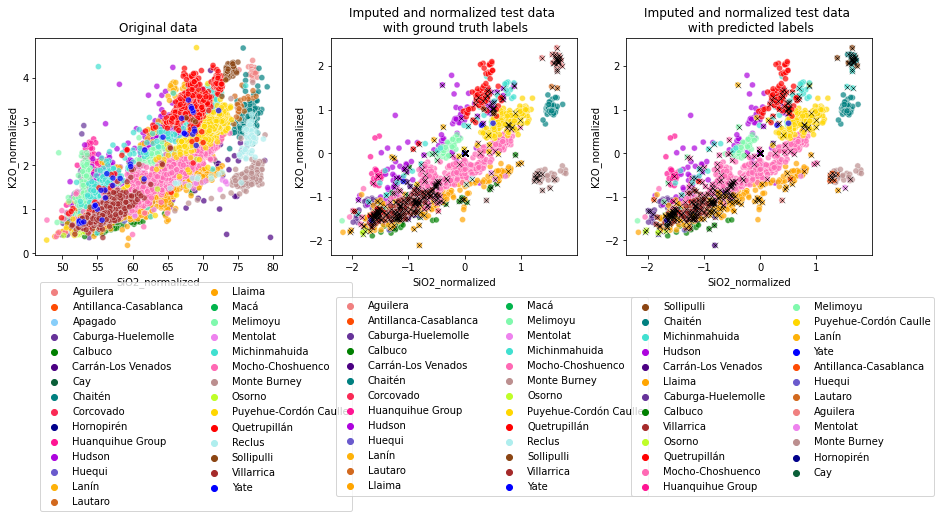

In [54]:
volcano_list = df.Volcano.cat.categories
best_est = est.best_estimator_

plot_scatterplots(
    X_onlymajor_volcanoes, yv_major, X_test_out, yv_test_out,
    best_est, pred, volcano_list
)

**Plot the confusion matrix**

<ipython-input-43-9809eb884322>:7: RuntimeWarning:

invalid value encountered in true_divide

<ipython-input-43-9809eb884322>:18: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



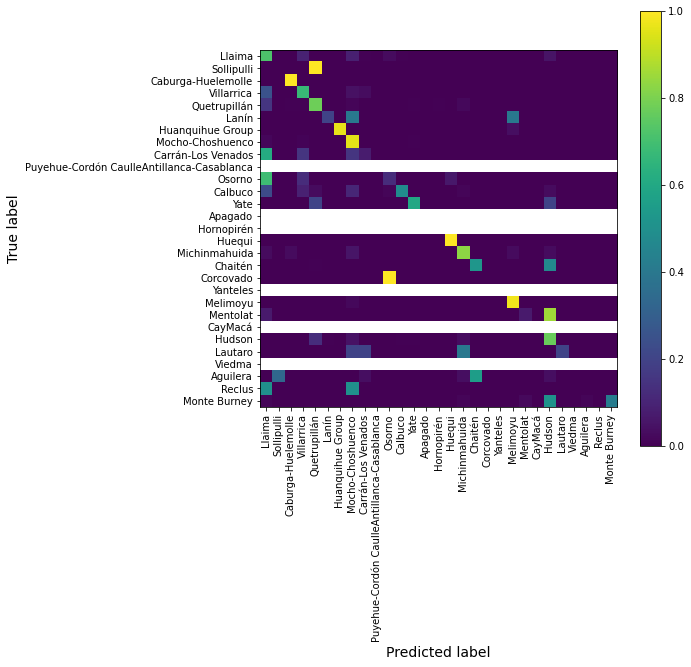

In [55]:
yv_test_names = df.Volcano.cat.categories[yv_test_out]
yv_pred_names = df.Volcano.cat.categories[pred]

plot_confusion_matrix(yv_test_names, yv_pred_names, labels=volcanoes_by_latitude)

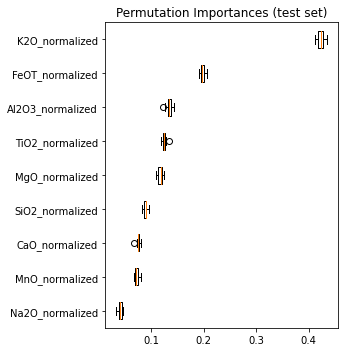

In [57]:
result = permutation_importance(
    best_est, X_test_out, yv_test_out, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(5,5))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False,
    labels=X_test_out.columns[sorted_idx]
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()

### 4 - Learn a model with event as target variable and all chemical elements as features.

**Visualize data**

In [65]:
# Print the number of sample observations per class
unique, counts = np.unique(ye, return_counts=True)
n_less_5samples = []
for u, c in zip(unique, counts):
    volcan = df_events.Event.cat.categories[u]
    print(f'id: {u}, volcán: \033[1m{volcan}\033[0m, sample observations: {c}')
    if c < 5:
        n_less_5samples.append(volcan)

n_classes = len(unique)

id: 0, volcán: 1640 Llaima, sample observations: 7
id: 1, volcán: 1751 Llaima, sample observations: 10
id: 2, volcán: 1780 Llaima, sample observations: 8
id: 3, volcán: 1852 Llaima, sample observations: 186
id: 4, volcán: 1903 Llaima, sample observations: 2
id: 5, volcán: 1945 Llaima, sample observations: 2
id: 6, volcán: 1957 Llaima, sample observations: 41
id: 7, volcán: 1994 Llaima, sample observations: 5
id: 8, volcán: 2008 Llaima, sample observations: 63
id: 9, volcán: ?11.7 ka MEN, sample observations: 38
id: 10, volcán: A1, sample observations: 42
id: 11, volcán: Achen, sample observations: 128
id: 12, volcán: Alerce Ignimbrite, sample observations: 6
id: 13, volcán: Alpehué, sample observations: 69
id: 14, volcán: Ap1, sample observations: 42
id: 15, volcán: Arauco, sample observations: 287
id: 16, volcán: Ca1, sample observations: 1
id: 17, volcán: Ca10, sample observations: 1
id: 18, volcán: Ca12, sample observations: 2
id: 19, volcán: Ca13, sample observations: 2
id: 20, vol

<AxesSubplot:>

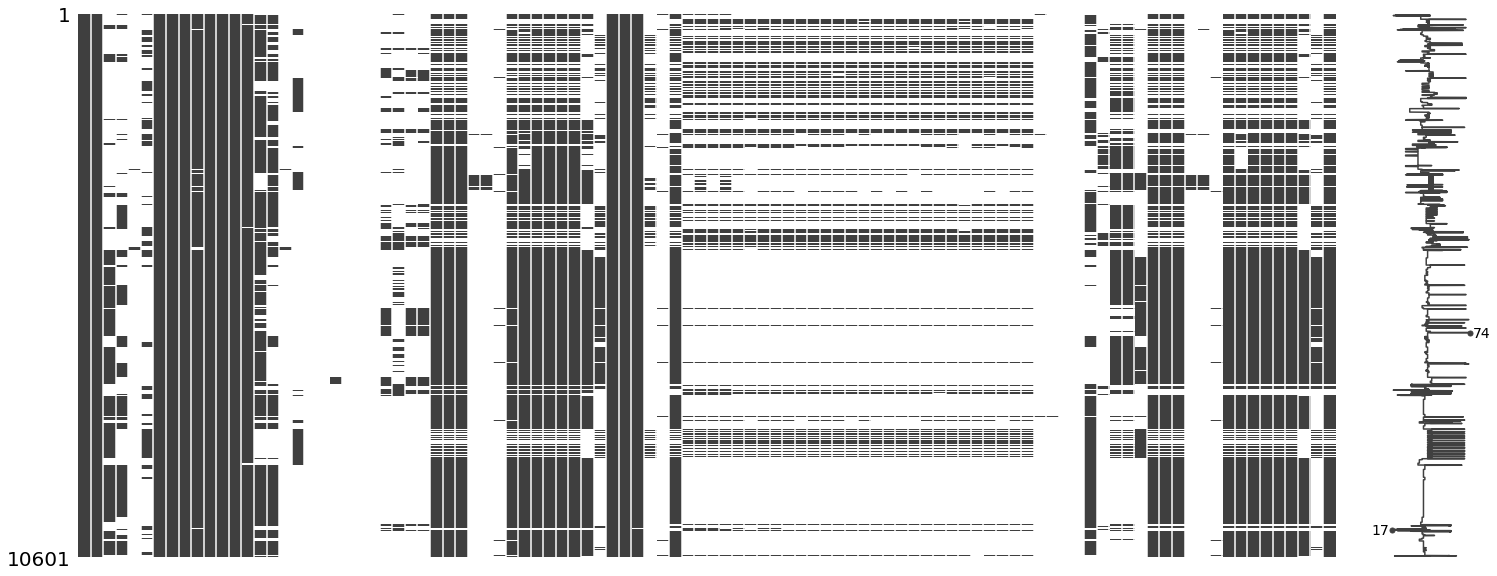

In [63]:
# Visualizing missingness
msno.matrix(df_events)

In [66]:
n_less_5samples

['1903 Llaima',
 '1945 Llaima',
 'Ca1',
 'Ca10',
 'Ca12',
 'Ca13',
 'Ca3',
 'Ca4',
 'Ca5',
 'Ca7',
 'Ca8',
 'Calbuco 1893',
 'Calbuco 1929',
 'Calbuco 1961',
 'Calbuco 1971?',
 'Chufquén',
 'Hudson1971',
 'Lautaro1933',
 'MC26',
 'MC27',
 'MIC1',
 'Pilmaiquén',
 'T1',
 'T2',
 'Villarrica 1971',
 'Villarrica 1984',
 'Ya1',
 'YaSc']

Checking wether all events are associated to at least 2 SampleIDs.

In [67]:
co = pd.crosstab(df.Event, df.SampleID)
_, n_sampleID = co.shape
print(f'There are {n_sampleID} unique samples IDs')

There are 2384 unique samples IDs


In [71]:
is_nonzero = co > 0
n_event_per_sampleID = is_nonzero.sum(axis=0)
unique, counts = np.unique(n_event_per_sampleID, return_counts=True)
ind_ids = np.where(is_nonzero.sum(axis=0) == 2)[0]
print(f'There are {len(ind_ids)} sampleIDs which contain several observations from several volcanoes:')
print([co.columns[ind_ids].values[i] for i in range(len(ind_ids))])

There are 14 sampleIDs which contain several observations from several volcanoes:
['123_03A', '130107-05F', '130107-05G', '226_05A', 'CLD168E', 'CLD177D', 'CLD182E', 'CLD182G', 'CLD243B', 'JK206', 'JK239', 'JK261b', 'T-35', 'T-36']


In [72]:
n_sampleID_per_event = is_nonzero.sum(axis=1)
ind_ids = np.where(n_sampleID_per_volcan == 1)[0]
print(f'There is {len(ind_ids)} events whose observations all come from the same sample IDs:')
print([co.index[i] for i in ind_ids])

There is 1 events whose observations all come from the same sample IDs:
['Calbuco 1961']


In [82]:
event_list = df.Event.cat.categories
ind = np.where(event_list[ye] != co.index[ind_ids[0]])[0]
ye = ye[ind]
X_events = X_events.iloc[ind]
SampleID_events = SampleID_events[ind]

**Running grid search on a single train-test split**

In [86]:
imp = SimpleImputer()
est = GradientBoostingClassifier(n_estimators=100, min_samples_leaf=1)
clf = make_pipeline(imp, StandardScaler(), est)
grid = {'gradientboostingclassifier__n_estimators': [100, 200],
        'gradientboostingclassifier__min_samples_leaf': [1, 5]}

gss = GroupShuffleSplit(test_size=.20, n_splits=1, random_state=0)

train_out, test_out = next(gss.split(X_events, groups=SampleID_events))
X_train_out = X_events.iloc[train_out]
yv_train_out = ye[train_out]
X_test_out = X_events.iloc[test_out]
yv_test_out = ye[test_out]
groups_train_out = SampleID_events[train_out]

est = GridSearchCV_with_groups(clf, grid, cv_test_size=0.2, cv_n_splits=5)
est.fit(X_train_out, yv_train_out, groups_train_out)
pred = est.predict(X_test_out)
ac = accuracy_score(yv_test_out, pred)
bc = balanced_accuracy_score(yv_test_out, pred)

print(f'Test set accuracy: {ac}')
print(f'Test set Balanced accuracy: {bc}')

Test set accuracy: 0.6353290450272142
Test set Balanced accuracy: 0.32725148878132626


/Users/lemorvan/opt/miniconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1854: UserWarning:

y_pred contains classes not in y_true



**Plot predictions as scatter plot**

IndexError: index 0 is out of bounds for axis 0 with size 0

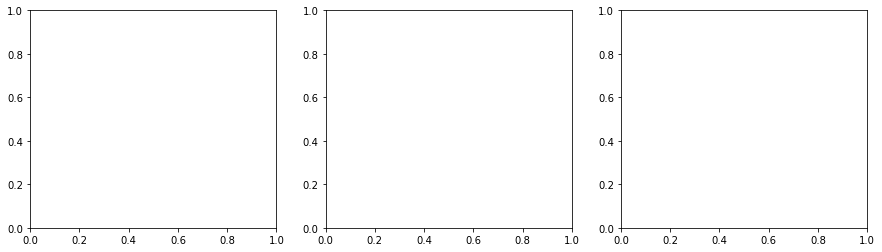

In [89]:
event_list = df.Event.cat.categories
best_est = est.best_estimator_

plot_scatterplots(
    X_events, ye, X_test_out, yv_test_out,
    best_est, pred, event_list, target_type='event'
)

**Plot the confusion matrix**

<ipython-input-43-9809eb884322>:7: RuntimeWarning:

invalid value encountered in true_divide

<ipython-input-43-9809eb884322>:18: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



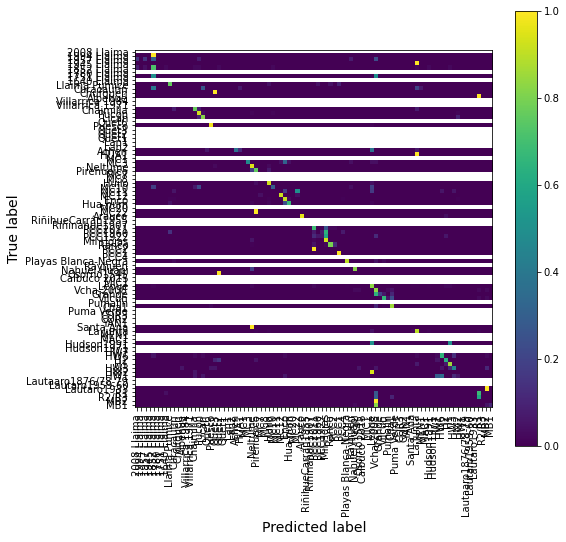

In [90]:
events_by_volcano = np.array([
    '2008 Llaima','1994 Llaima','1957 Llaima','1945 Llaima','1852 Llaima',   #Llaima
    '1780 Llaima','1751 Llaima','1640 Llaima','Llaima Pumice', 
    'Curacautín',                
    'Chufquén','Alpehué',                                                    #Sollipulli
                                                                             #Caburga-Huelemolle
    'Villarrica 1984','Villarrica 1971','Chaimilla','Pucón','Licán',         #Villarica
    'Quet6','Puesco','Quet3','Quet2','Quet1',                                #Quetrupillán
            'Lan1', 'Lan2',                                                  #Lanín
    'Achen','HUA1',                                                          #Huanquihue Group
    'MC1','MC3','Neltume','Pirehueico','MC7', 'MC8', 'Huilo','MC10','MC11',  #Mocho-Choshuenco
    'MC12','Enco','Hua-hum', 'MC20','MC22','Arauco', 'Riñihue'               
    'Carrán1955', 'Riñinahue1907',                                           #Carrán-Los Venados
    'PCC2011','PCC1960','PCC1922','Mil Hojas','Ranco','PCC2','PCC1','PCC4',  #PCC
    'Playas Blanca-Negra','Rayhuen','Nahuel Huapi',                          #Antillanca-Casablanca
    'Osorno1545',                                                            #Osorno
    'Calbuco 2015',                                                          #Calbuco
                                                                             #Yate
                                                                             #Apagado
                                                                             #Hornopirén
                                                                             #Huequi
    'MIC1','Lepué',                                                          #Michinmahuida                                                  
    'Vcha-2008','Grande','Vilcún','Pumalín','Cha1','Puma Verde',             #Chaitén
    'COR3','COR2',                                                           #Corcovado
    'YAN1',                                                                  #Yanteles
    'Santa Ana', 'La Junta',                                                 #Melimoyu
    'MEN1',                                                                  #Mentolat
                                                                             #Cay
    'MAC1',                                                                  #Macá
    'Hudson1991','Hudson1971','HW7','HW6','H2','H1','HW3','HW2','HW1',       #Hudson
    'Lautaaro1876/78-79','Lautaro1959-60','Lautaro1933',                     #Lautaron
                                                                             #Viedma
                                                                             #Aguilera
    'R1', 'R2/R3',                                                           #Reclus
    'MB2','MB1'])                                                             #Burney
        

yv_test_names = df.Event.cat.categories[yv_test_out]
yv_pred_names = df.Event.cat.categories[pred]

plot_confusion_matrix(yv_test_names, yv_pred_names, labels=events_by_volcano)

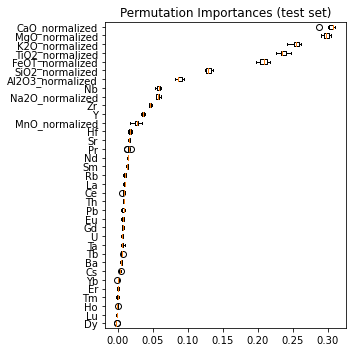

In [91]:
result = permutation_importance(
    best_est, X_test_out, yv_test_out, n_repeats=10, random_state=42, n_jobs=2
)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(5,5))
ax.boxplot(
    result.importances[sorted_idx].T, vert=False,
    labels=X_test_out.columns[sorted_idx]
)
ax.set_title("Permutation Importances (test set)")
fig.tight_layout()
plt.show()